<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/ConvLSTM_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install imageio
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Reshape, LeakyReLU, Conv2DTranspose, Conv3DTranspose, ConvLSTM2D, BatchNormalization, LayerNormalization, TimeDistributed, Conv2D, Conv3D, ZeroPadding3D, MaxPooling2D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model, Model
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
from keras import backend
from keras.constraints import Constraint
tf.keras.backend.set_floatx('float32')
from matplotlib import pyplot

In [0]:
class Config:
    def __init__(self, data_dir):
        self.DATASET_PATH = join(data_dir,"UCSDped1/Train/")
        self.TEST_DIR = join(data_dir,"UCSDped1/Test/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 5
        self.GEN_MODEL_PATH = join(data_dir,"model_gen_Conv2DLSTM_WGAN.hdf5")
        self.DIS_MODEL_PATH = join(data_dir,"model_dis_Conv2DLSTM_WGAN.hdf5")
        self.GAN_MODEL_PATH = join(data_dir,"model_combined_Conv2DLSTM_WGAN.hdf5")
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.n_critic = 5
        self.r_alpha = 0.0000000000000000000001

class ModelContainer:
  def __init__(self, y0, y1, y2):
     self.generator = y0
     self.discriminator = y1
     self.gan = y2

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}
 

conf = Config(data_dir="/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/") 
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass

In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 32 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_clips_list(seq_size):
    """
    seq_size :int 
        The sequence size of individual clip
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 32-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seq_size))
    return clips


def get_single_test(single_test_path, sz):
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def evaluate(test_case_dir, model, sz, gen_only):

    test = get_single_test(join(conf.TEST_DIR,test_case_dir), sz)
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences, sr = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    
    if gen_only == 1:

        for i in range(0, sz):
            cv2_imshow(np.reshape(reconstructed_sequences[i][0],(256, 256))*256)
            cv2.waitKey()

        #reconstruction_shape = (sz,10, 256, 256, 1)
        #sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
        #sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
        #sr = 1.0 - sa
    #print(sr.shape())

    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [19]:

def get_generator():
    #if reload_model == True and os.path.isfile(conf.GEN_MODEL_PATH):
    #    model=load_model(conf.GEN_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    #    return model, True

    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    
    print("Loading generator model")
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (11, 11), strides=(4,4), activation="relu", kernel_initializer=init, padding="same"), batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))   
    model.add(BatchNormalization())
    model.add(TimeDistributed(Conv2D(32, (5, 5), strides=(2,2), activation="relu", kernel_initializer=init, padding="same")))
    model.add(BatchNormalization())
    #seq.add(Conv3D(16, (3, 3, 3), activation="relu", strides=(1, 2, 2), padding="same"))
    #eq.add(BatchNormalization())
    # # # # #
    model.add(ConvLSTM2D(32, (3, 3), kernel_initializer=init, padding="same", return_sequences=True))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(16, (3, 3), kernel_initializer=init, padding="same", return_sequences=True))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(32, (3, 3), kernel_initializer=init, padding="same", return_sequences=True))
    model.add(BatchNormalization())
    # # # # #
    #seq.add(Conv3DTranspose(16, (3, 3, 3), activation="relu", strides=(1, 2, 2), padding="same"))
    model.add(TimeDistributed(Conv2DTranspose(32, (5, 5), strides=(2,2), activation="relu", kernel_initializer=init, padding="same")))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Conv2DTranspose(32, (11, 11), strides=(4,4), activation="relu", kernel_initializer=init, padding="same")))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Conv2D(1, (11, 11), activation="tanh", kernel_initializer=init,  padding="same")))
    #optimizer = tf.keras.optimizers.RMSprop(lr=0.002, clipvalue=1.0, decay=1e-8)
    #seq.compile(optimizer=optimizer, loss='binary_crossentropy')
    model.summary(line_length=150)
    return model


def get_discriminator():

    #if reload_model == True and os.path.isfile(conf.DIS_MODEL_PATH):
    #    model=load_model(conf.DIS_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    #    return model, True
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    model = Sequential()

    # 1st layer group
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),name="conv1", 
                             strides=(1, 1), kernel_initializer=init, kernel_constraint=const, padding="valid"),batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))  
    #model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool1", padding="valid"))
    model.add(BatchNormalization())
    # 2nd layer group  
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),name="conv2", 
                     strides=(1, 1, 1), kernel_initializer=init, kernel_constraint=const, padding="valid")))
    #model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool2", padding="valid"))
    model.add(BatchNormalization())
   
    model.add(TimeDistributed(Conv2D(64, (5, 5, 5), activation=tf.keras.layers.LeakyReLU(alpha=0.1),name="conv4", 
                     strides=(1, 1, 1), kernel_initializer=init, kernel_constraint=const, padding="valid"))) 
    #model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool3", padding="valid"))
    model.add(BatchNormalization())
    model.add(Flatten())
    
    model.add(Dense(1, activation='linear'))
   
    model.summary(line_length=150)
    return model

def get_discriminator_v1():

    #if reload_model == True and os.path.isfile(conf.DIS_MODEL_PATH):
    #    model=load_model(conf.DIS_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    #    return model, True
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    model = Sequential()

    # 1st layer group
    model.add(Conv3D(16, (3, 3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),name="conv1", 
                     batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4),
                     strides=(1, 1, 1), kernel_initializer=init, kernel_constraint=const, padding="valid"))  
    #model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool1", padding="valid"))
    model.add(BatchNormalization())
    # 2nd layer group  
    model.add(Conv3D(32, (3, 3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),name="conv2", 
                     strides=(1, 1, 1), kernel_initializer=init, kernel_constraint=const, padding="valid"))
    #model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool2", padding="valid"))
    model.add(BatchNormalization())
   
    model.add(Conv3D(64, (5, 5, 5), activation=tf.keras.layers.LeakyReLU(alpha=0.1),name="conv4", 
                     strides=(1, 1, 1), kernel_initializer=init, kernel_constraint=const, padding="valid"))   
    #model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool3", padding="valid"))
    model.add(BatchNormalization())
    model.add(Flatten())
    
    model.add(Dense(1, activation='linear'))
   
    model.summary(line_length=150)
    return model

def build_model(model, image_dims):
    input_img = Input(shape=image_dims)
    output = model(input_img)
    return Model(input_img,output)





#https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f   
#https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/
#https://arxiv.org/pdf/1802.09088.pdf
get_generator()
get_discriminator()

Loading generator model
Model: "sequential_8"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
time_distributed_20 (TimeDistributed)                              (None, 10, 64, 64, 32)                                      3904                   
______________________________________________________________________________________________________________________________________________________
batch_normalization_40 (BatchNormalization)                        (None, 10, 64, 64, 32)                                      128                    
______________________________________________________________________________________________________________________________________________________
time_distributed_21 (TimeDistributed)           

In [0]:

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)
 


# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('plot_line_plot_loss.png')
	pyplot.close()
 

def compile_gan(generator, discriminator):
    image_dims = [conf.dim1, conf.dim2, conf.dim3, conf.dim4]
    optimizer = tf.keras.optimizers.RMSprop(lr=0.00005)
    built_dis =  build_model(discriminator, image_dims)

    built_dis.compile(optimizer=optimizer, loss=wasserstein_loss)

    built_gen = build_model(generator, image_dims)
    img = Input(shape=image_dims)

    reconstructed_img = built_gen(img)

    built_dis.trainable = False
    validity = built_dis(reconstructed_img)

    gan_model = Model(img, [reconstructed_img, validity])
    gan_model.compile(loss=[wasserstein_loss, wasserstein_loss],
    loss_weights=[conf.r_alpha, 1],
    optimizer=optimizer)

    return ModelContainer(built_gen, built_dis, gan_model)
    
def train_step(models, batch_clips, c1_hist, c2_hist):
    batch_noise_clips = np.multiply(batch_clips*256, np.random.normal(0, 1, size=(conf.BATCH_SIZE, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))/256
    batch_fake_clips = models.generator.predict_on_batch(batch_noise_clips)
    c1_tmp, c2_tmp = list(), list()
    for _ in range(conf.n_critic):
        d_loss_real = models.discriminator.train_on_batch(batch_clips, -1*np.ones(shape=(conf.BATCH_SIZE,1)))
        c1_tmp.append(d_loss_real)
        d_loss_fake = models.discriminator.train_on_batch(batch_fake_clips, np.ones(shape=(conf.BATCH_SIZE,1)))
        c2_tmp.append(d_loss_fake)
        print(f'\t\t\t\t Discriminator Loss_Real: {d_loss_real} \t\t Loss_Fake: {d_loss_fake}\n')
    c1_hist.append(np.mean(c1_tmp))
    c2_hist.append(np.mean(c2_tmp))
    #models.gan.train_on_batch(batch_noise_clips, [batch_clips, np.ones(shape=(conf.BATCH_SIZE,1))])
    g_loss  = models.gan.train_on_batch(batch_noise_clips, [batch_clips, -1*np.ones(shape=(conf.BATCH_SIZE,1))])
    return  g_loss

def train():
    discriminator = get_discriminator()
    generator = get_generator()
    models = compile_gan(generator, discriminator)
    models.gan.summary()

    train_dataset = tf.data.Dataset.from_tensor_slices(np.array(get_clips_list(conf.dim1))).batch(conf.BATCH_SIZE)
    c1_hist, c2_hist, g_hist = list(), list(), list()
    for epoch in range(conf.EPOCHS):
        
        for batch in train_dataset:
            
            [total_weighted_loss, reconstruction_loss, fooling_loss] = train_step(models, batch, c1_hist, c2_hist)
            
            print(f'Epoch: {epoch} \t Discriminator Loss: {fooling_loss} \t\t Generator Loss: {reconstruction_loss} \t\t Total Loss: {total_weighted_loss}')
            g_hist.append(reconstruction_loss)
            #models.gan.reset_states()
        

        models.gan.save("training_gan/gan.hdf5", save_format='h5')
    
    models.generator.save(conf.GEN_MODEL_PATH,save_format='h5')
    models.discriminator.save(conf.DIS_MODEL_PATH,save_format='h5')
    models.gan.save(conf.GAN_MODEL_PATH, save_format='h5')
    plot_history(c1_hist, c2_hist, g_hist)
    return gan

mkdir: cannot create directory ‘training_gan’: File exists
Test case loaded


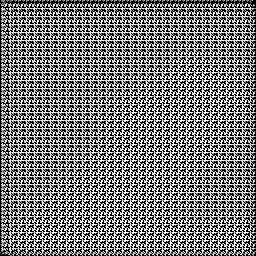

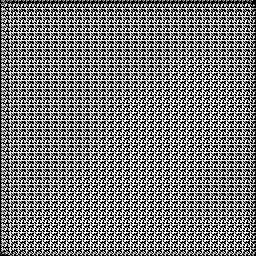

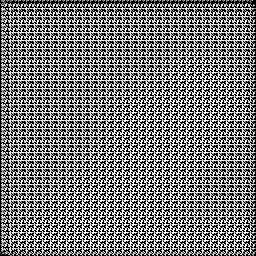

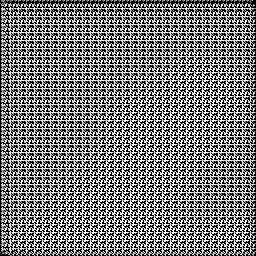

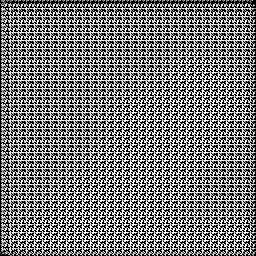

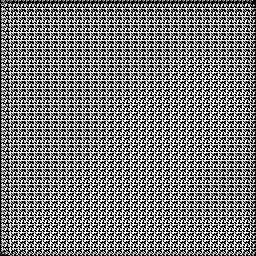

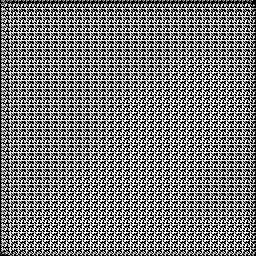

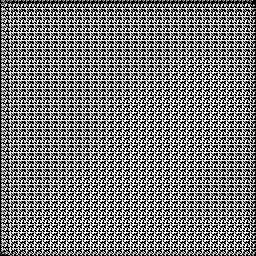

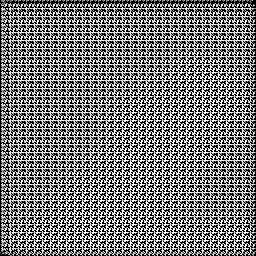

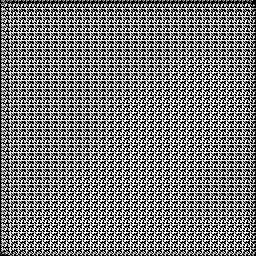

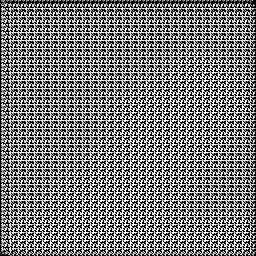

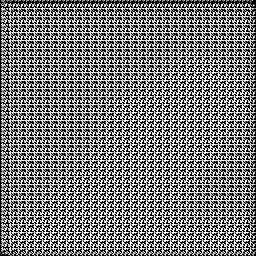

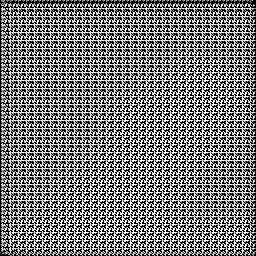

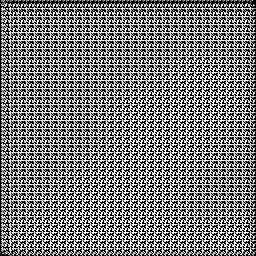

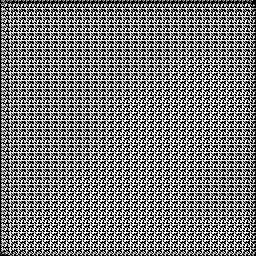

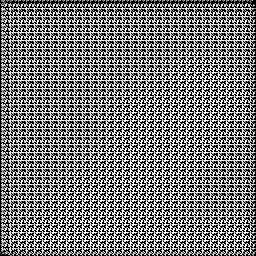

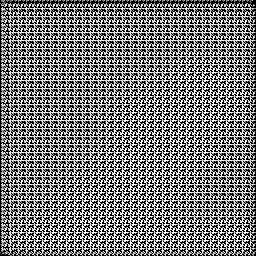

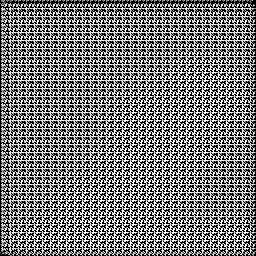

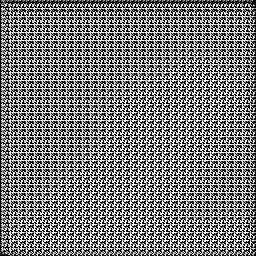

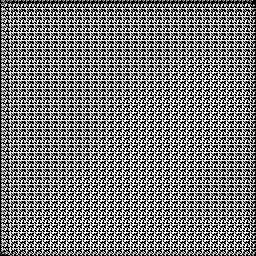

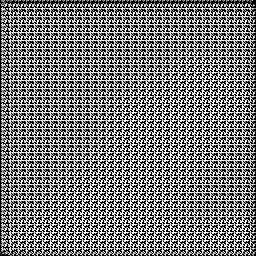

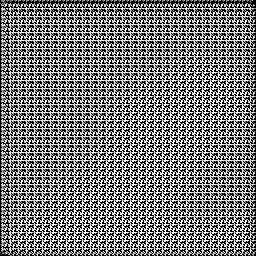

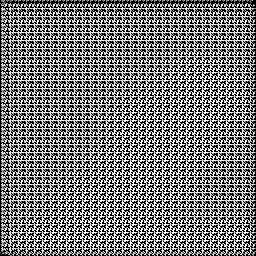

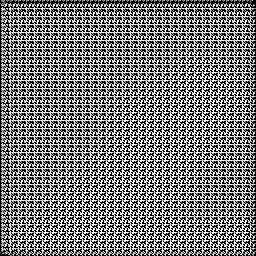

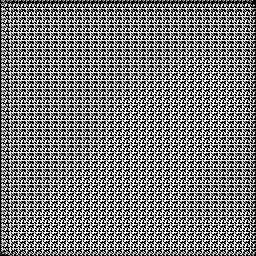

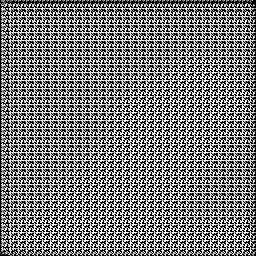

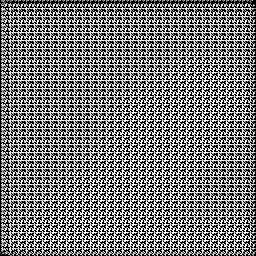

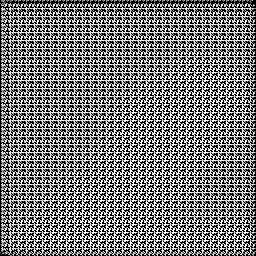

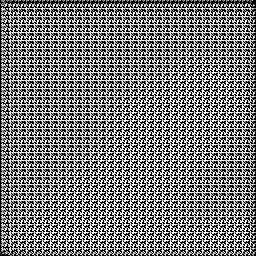

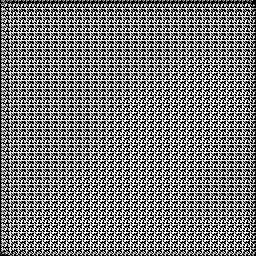

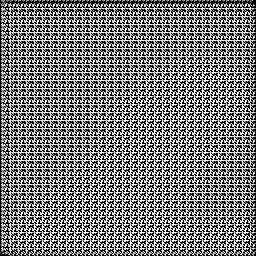

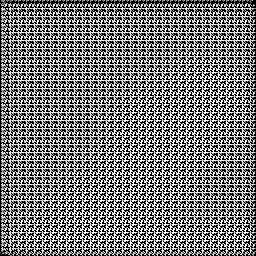

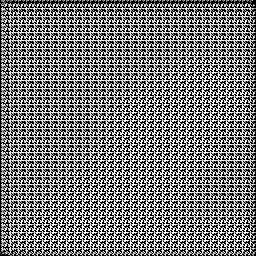

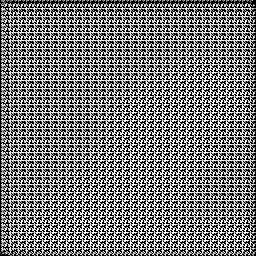

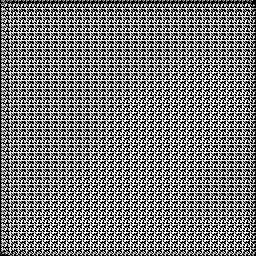

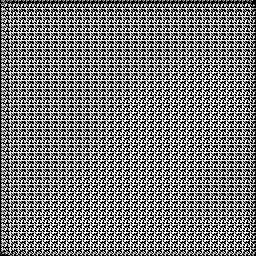

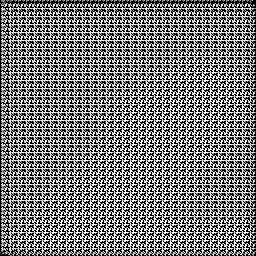

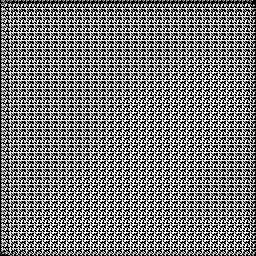

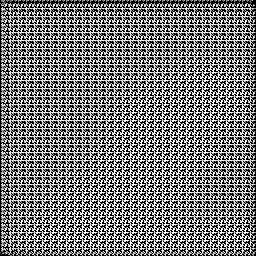

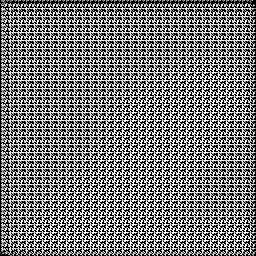

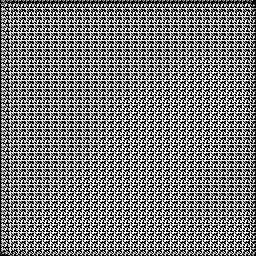

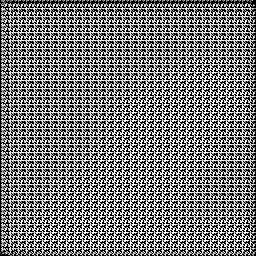

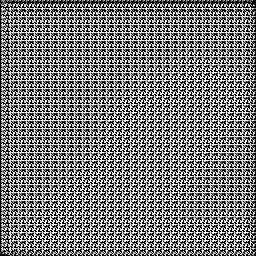

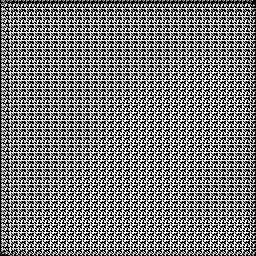

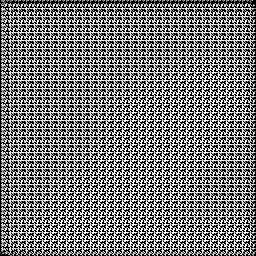

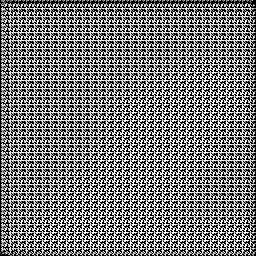

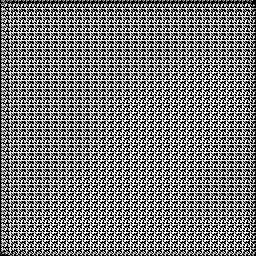

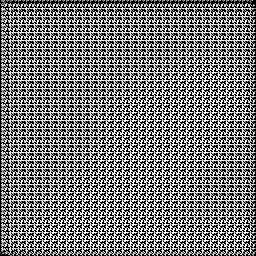

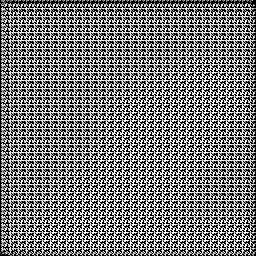

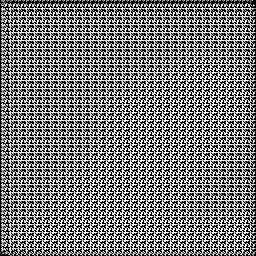

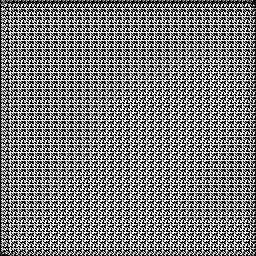

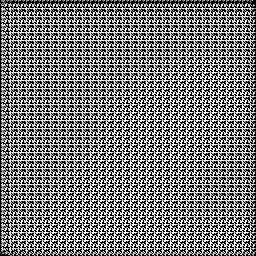

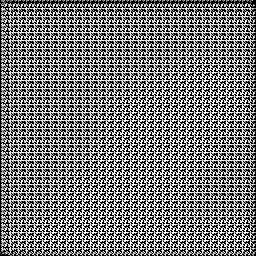

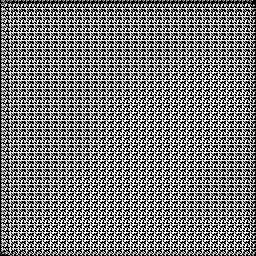

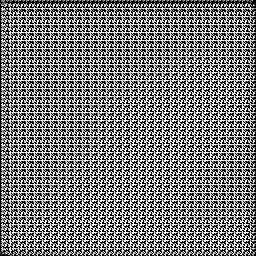

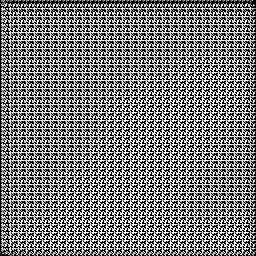

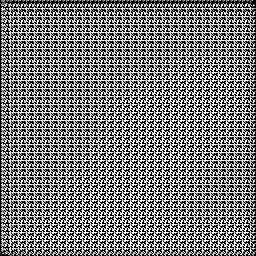

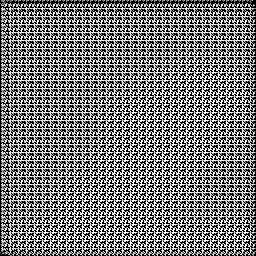

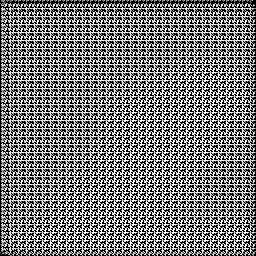

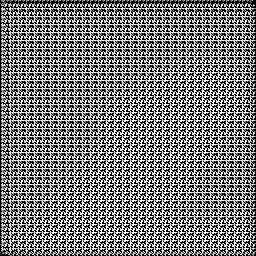

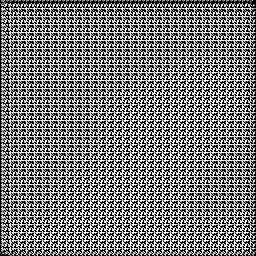

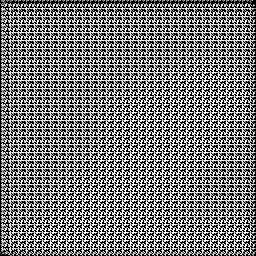

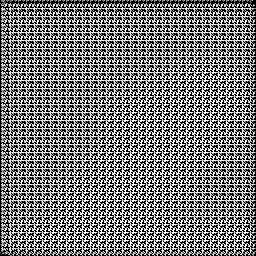

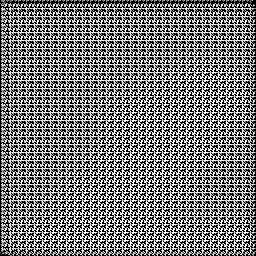

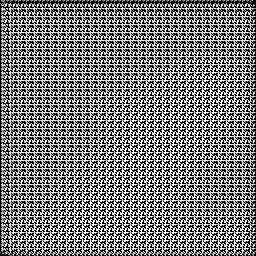

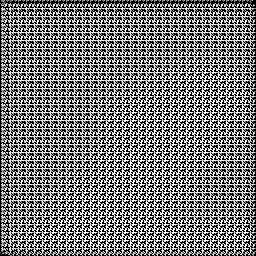

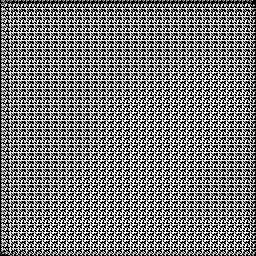

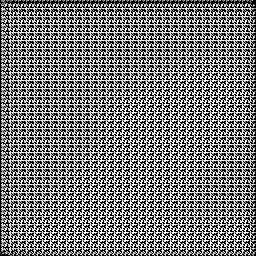

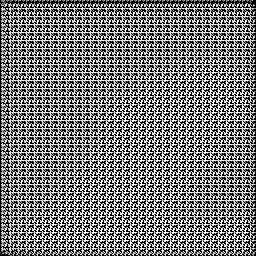

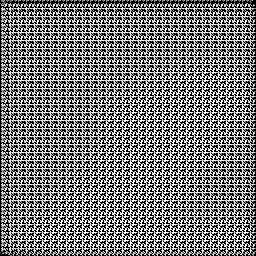

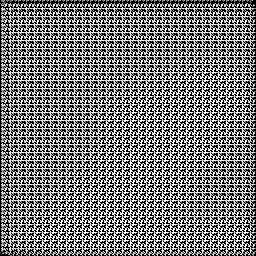

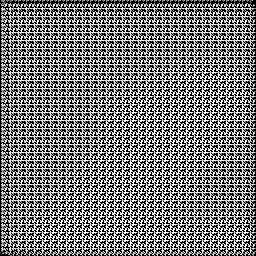

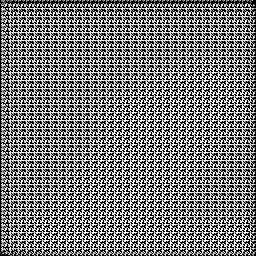

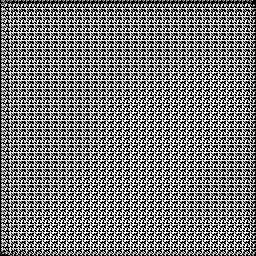

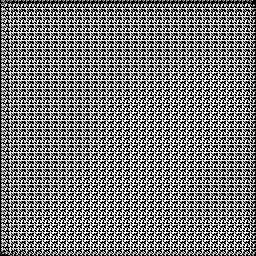

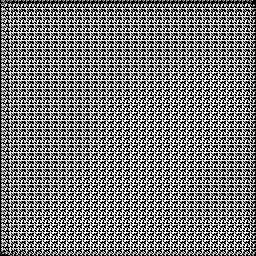

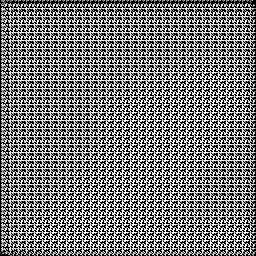

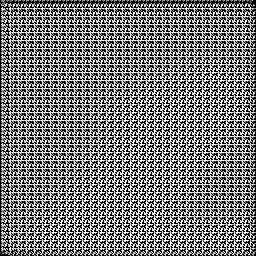

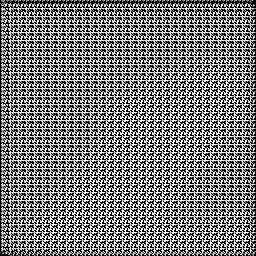

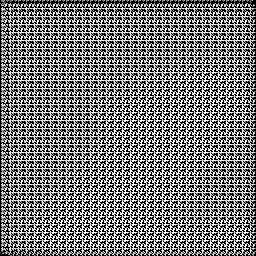

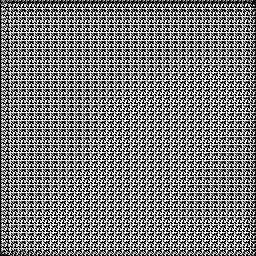

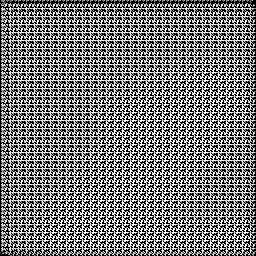

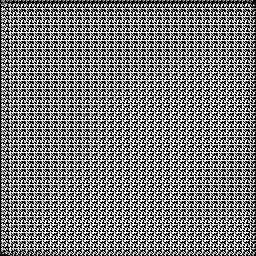

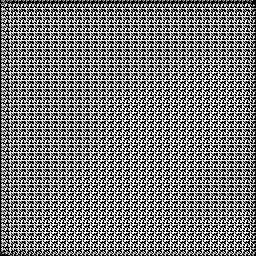

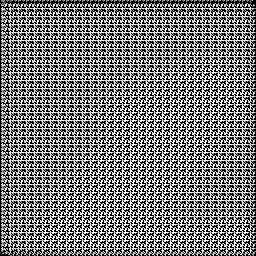

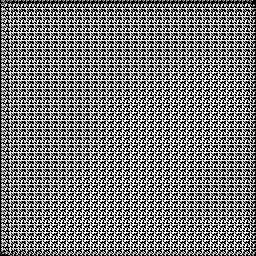

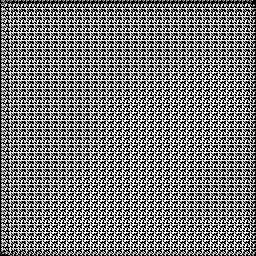

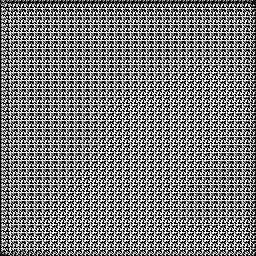

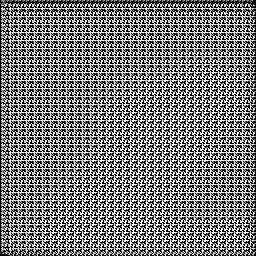

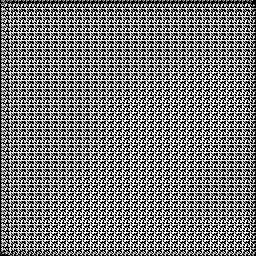

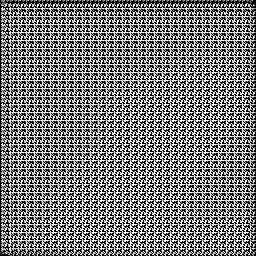

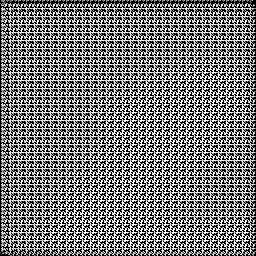

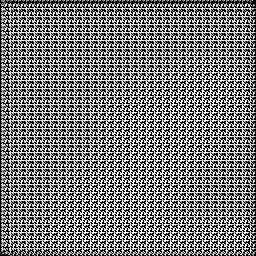

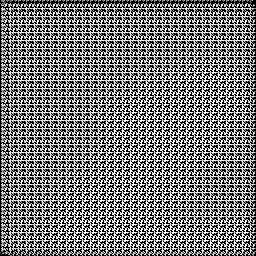

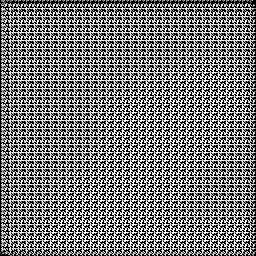

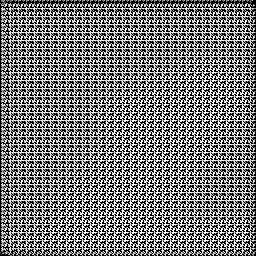

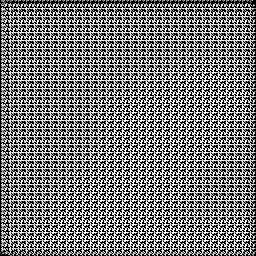

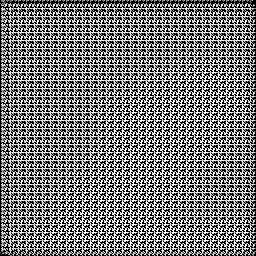

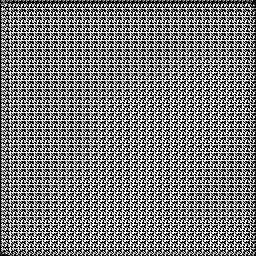

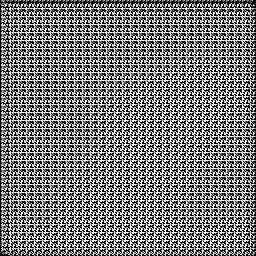

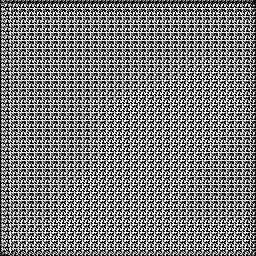

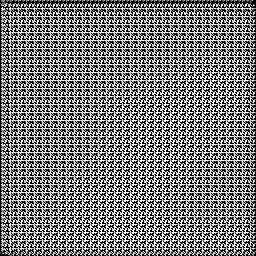

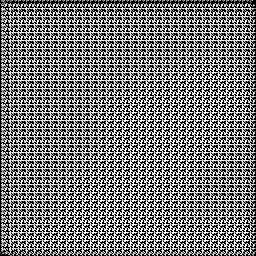

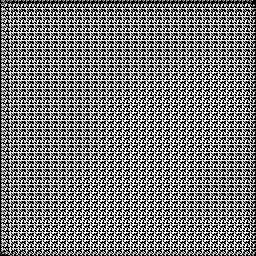

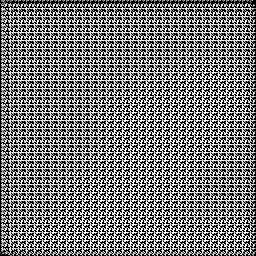

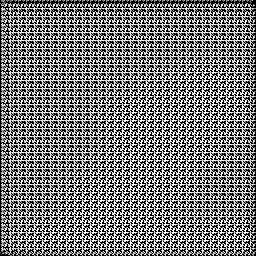

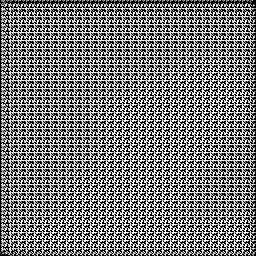

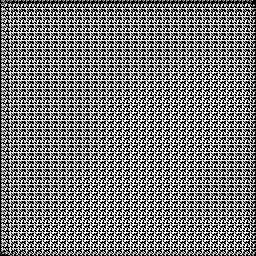

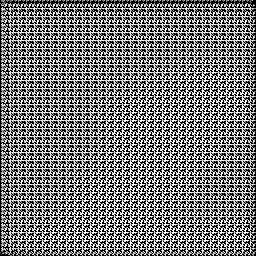

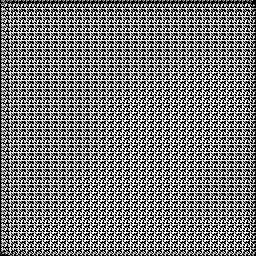

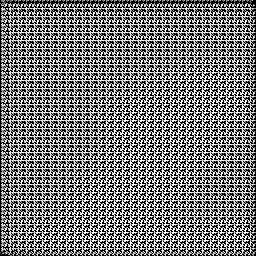

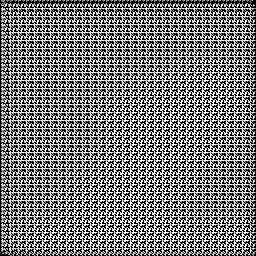

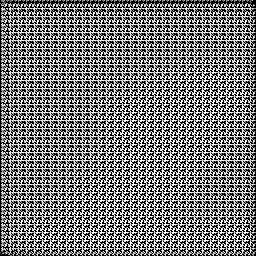

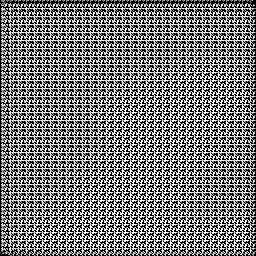

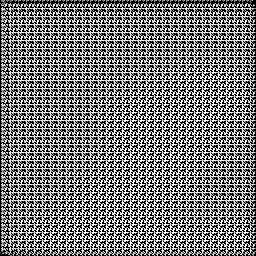

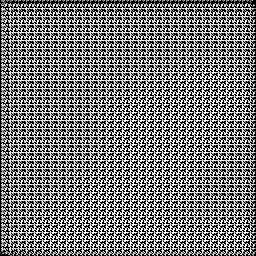

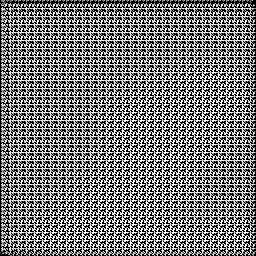

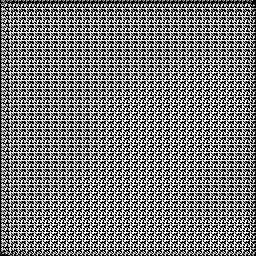

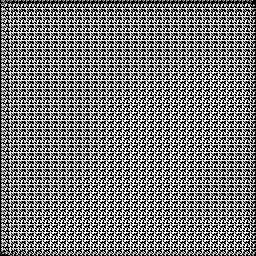

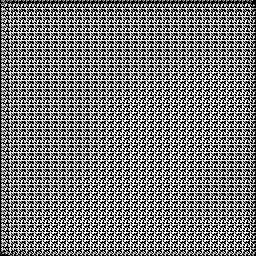

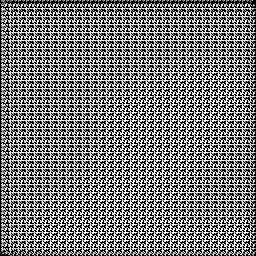

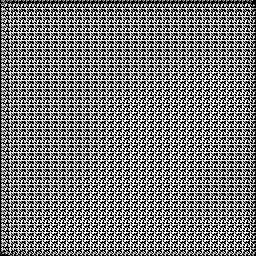

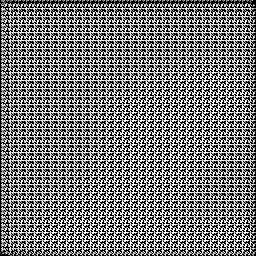

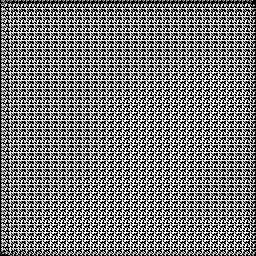

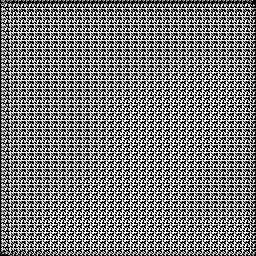

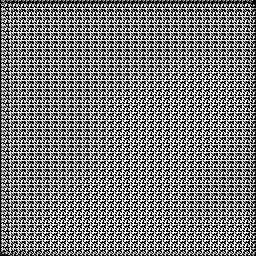

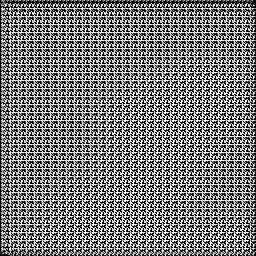

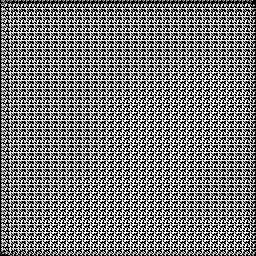

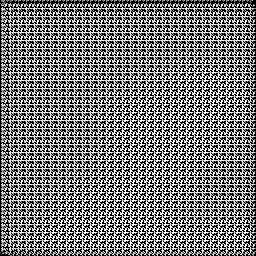

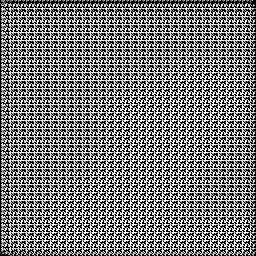

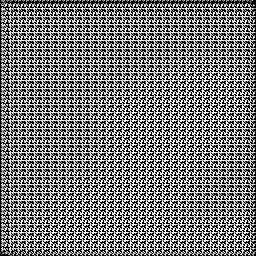

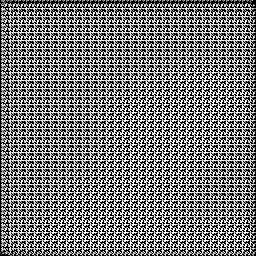

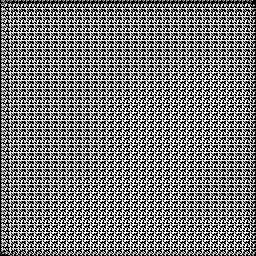

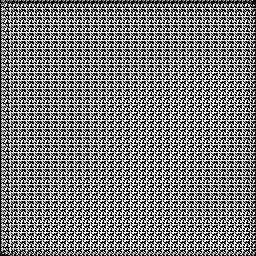

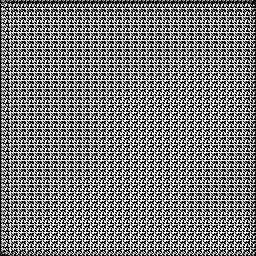

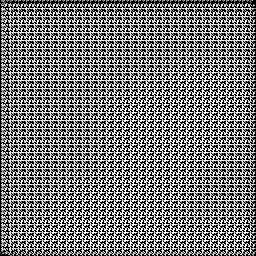

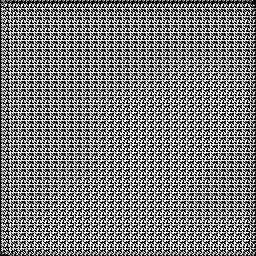

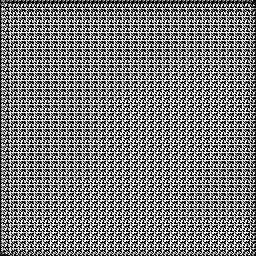

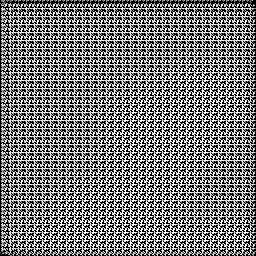

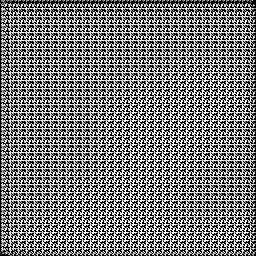

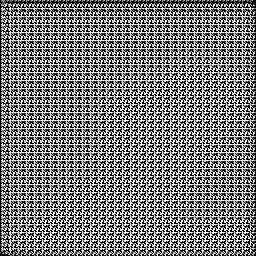

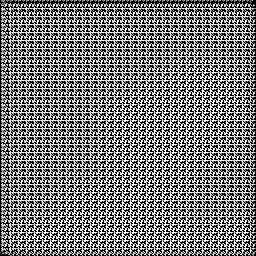

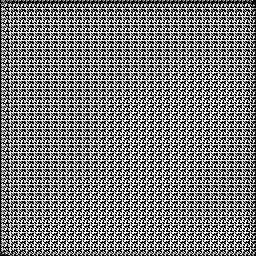

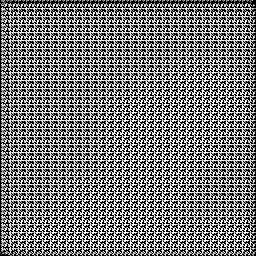

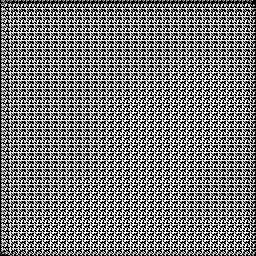

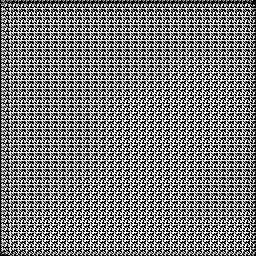

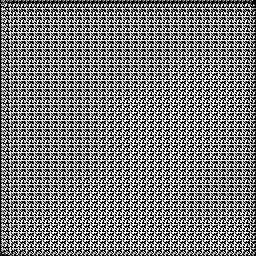

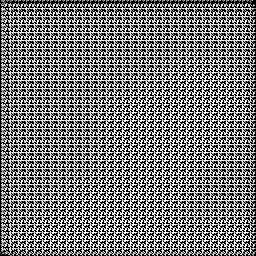

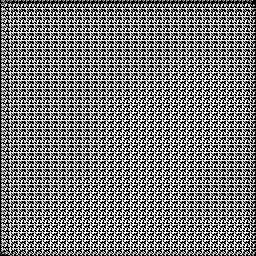

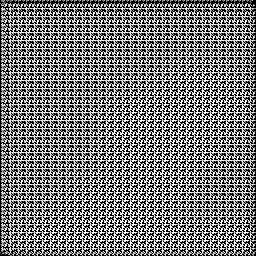

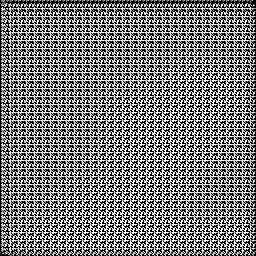

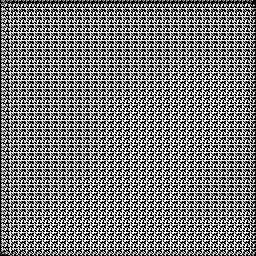

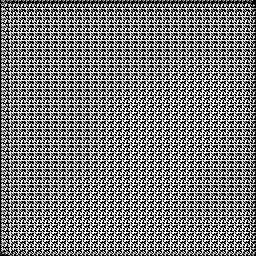

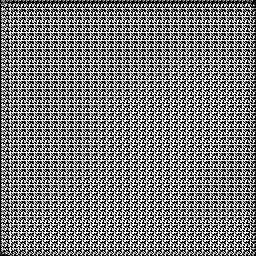

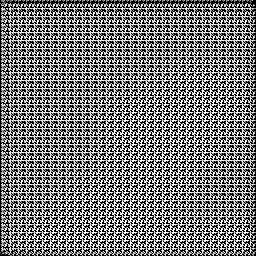

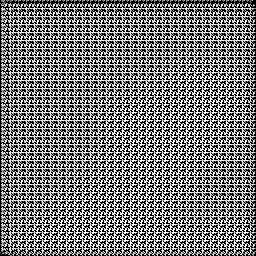

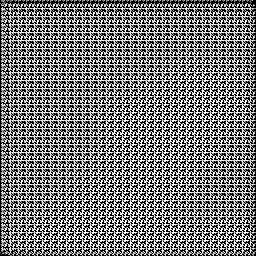

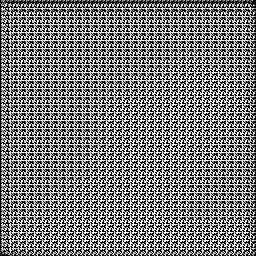

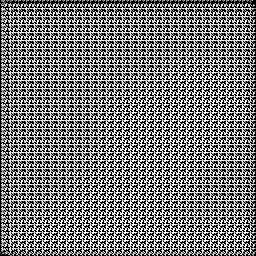

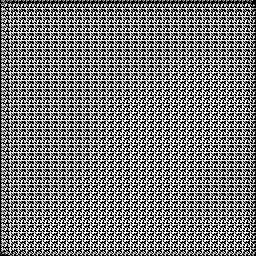

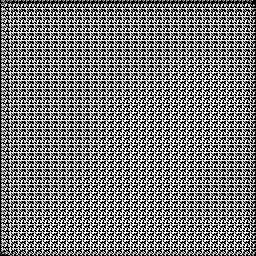

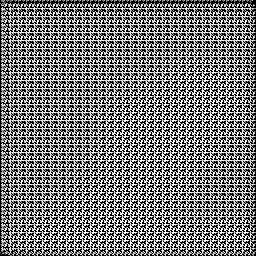

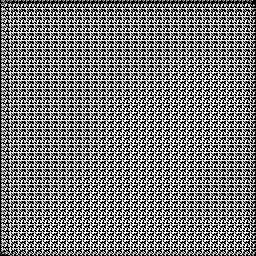

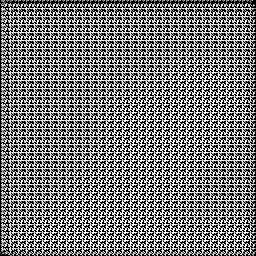

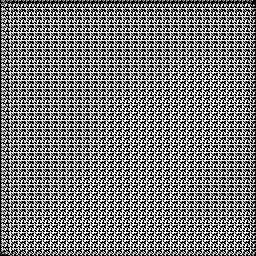

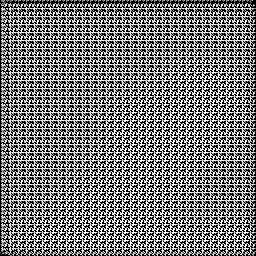

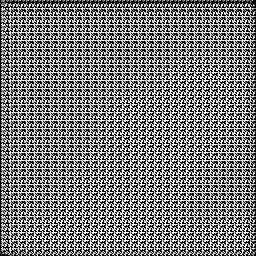

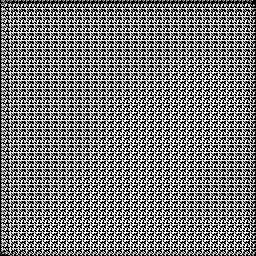

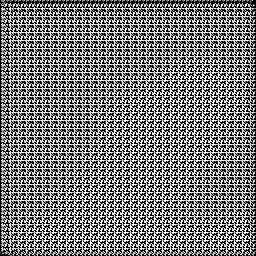

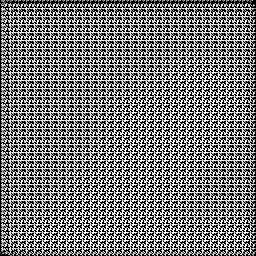

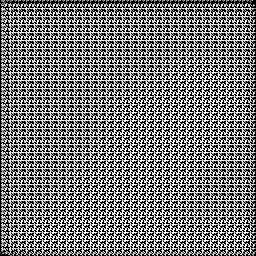

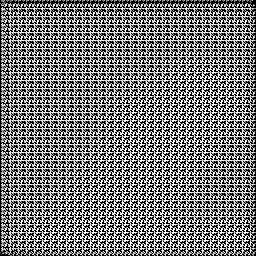

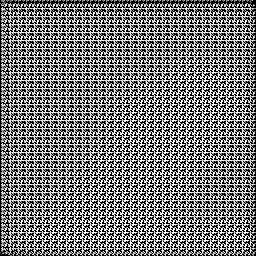

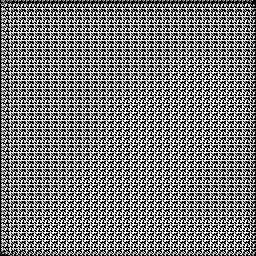

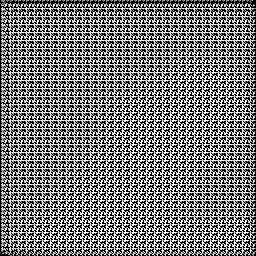

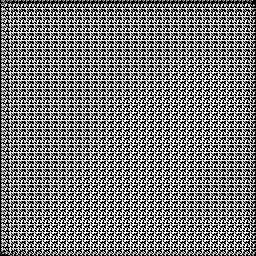

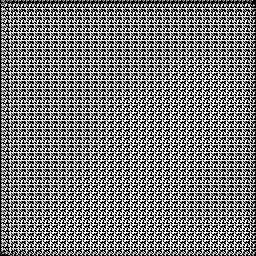

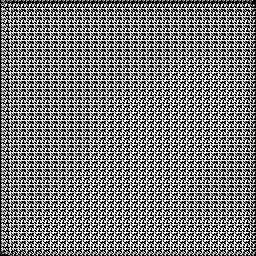

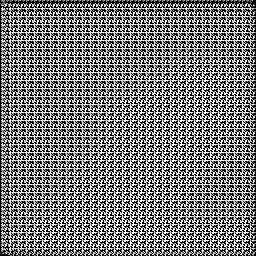

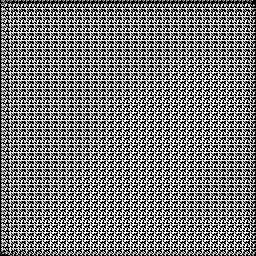

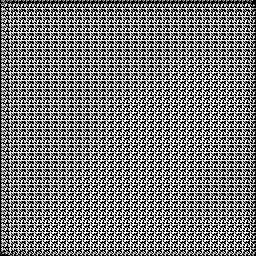

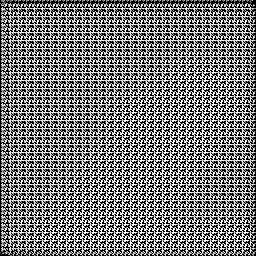

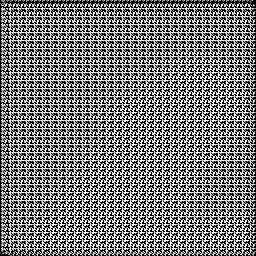

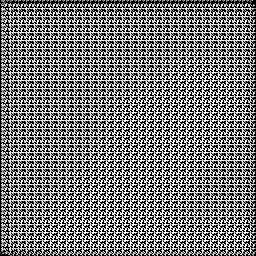

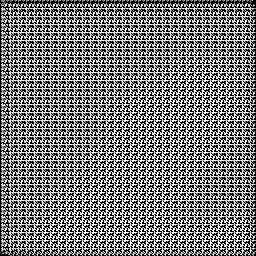

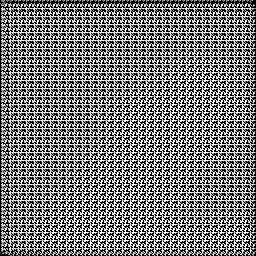

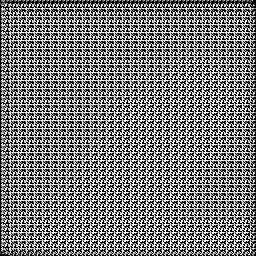

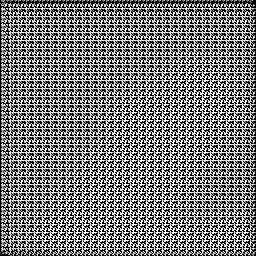

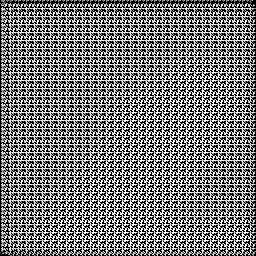

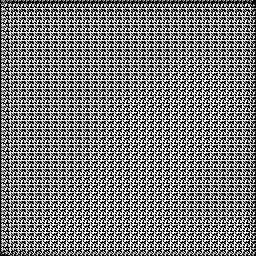

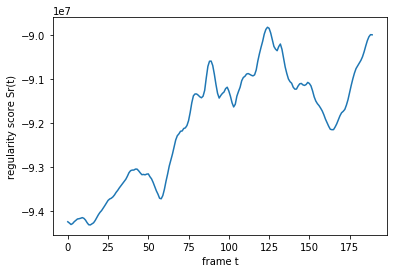

In [24]:
!rm training_gan/gan.hdf5 -rf
!mkdir training_gan
if os.path.isfile(conf.GAN_MODEL_PATH):
    model=load_model(conf.GAN_MODEL_PATH, custom_objects={'LeakyReLU': LeakyReLU, 'ClipConstraint': ClipConstraint, 'wasserstein_loss': wasserstein_loss})
else :
    model = train()

evaluate("Test002", model, 200, 1)